In [1]:
%matplotlib inline
from dask import array as da
import numpy as np
import xarray as xr
from gcsfs.mapping import GCSMap
from xhistogram.xarray import histogram as xhist
from matplotlib import pyplot as plt
import pandas as pd
from dask import delayed

In [2]:
# parameters
dataset_version = "v2019.09.11.2"
bucket_stokes = f"pangeo-parcels/med_sea_connectivity_{dataset_version}/traj_data_with_stokes.zarr"
bucket_nostokes = f"pangeo-parcels/med_sea_connectivity_{dataset_version}/traj_data_without_stokes.zarr"
thinning_data_percent = 10  # randomly thinning trajectories to 10%

In [3]:
from dask.distributed import Client, progress

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=8)
cluster.adapt(minimum=8, maximum=40, wait_count=15)
cluster

** ☝️ Don't forget to click the link above to view the scheduler dashboard! **

In [4]:
client = Client(cluster)
client

Client Scheduler: tcp://10.32.60.63:40139 Dashboard: /user/0000-0003-1951-8494/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [12]:
def open_dataset(bucket, restrict_to_MPA=None, restrict_to_z=None):
    # load data
    gcsmap = GCSMap(bucket)
    ds = xr.open_zarr(gcsmap, decode_cf=False)
    
    # get info on starting region and make it an easy-to-look-up coord
    initial_MPA = ds.MPA.isel(obs=0).squeeze()
    ds.coords["initial_MPA"] = initial_MPA
     
    # mask after land contact
    before_land_contact = ((ds.land == 0).cumprod("obs") == 1)
    ds = ds.where(before_land_contact)
      
    return ds

In [44]:
ds_stokes = open_dataset(bucket_stokes)
ds_nostokes = open_dataset(bucket_nostokes)

In [45]:
ds_stokes

<xarray.Dataset>
Dimensions:      (obs: 962, traj: 2625480)
Coordinates:
    initial_MPA  (traj) float32 dask.array<shape=(2625480,), chunksize=(100000,)>
Dimensions without coordinates: obs, traj
Data variables:
    MPA          (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    distance     (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    land         (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    lat          (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    lon          (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    temp         (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    time         (traj, obs) float64 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    z            (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
Attributes:
    Conventions

In [46]:
def apply_assumptions(ds):
    # We assume no vertical migration and hence
    # make (non-changing) depth level an easy to look up coord
    z = ds.z.isel(obs=0).squeeze()
    ds["z"] = z
    ds.coords["z"] = ds.z
    
    # We assume that all time steps are equal
    # and that the time axis is measured in seconds
    # since some reference period
    time_axis = ds.reset_coords(["z", "initial_MPA"]).time.isel(traj=0).squeeze()
    time_axis -= time_axis.isel(obs=0).squeeze()
    time_axis.attrs["units"] = "seconds since start of particle"
    ds.coords["time_axis"] = time_axis
    
    return ds

In [47]:
ds_stokes = apply_assumptions(ds_stokes)
ds_nostokes = apply_assumptions(ds_nostokes)

In [48]:
def persist_coords(ds):
    ds["z"] = ds["z"].persist(retries=40)
    ds["initial_MPA"] = ds["initial_MPA"].persist(retries=40)
    ds["time_axis"] = ds["time_axis"].persist(retries=40)
    return ds

In [49]:
ds_stokes = persist_coords(ds_stokes)
ds_nostokes = persist_coords(ds_nostokes)

In [50]:
def get_z_values(ds):
    z_values = da.unique(ds.z.data).compute(retries=40)
    z_values = z_values[~np.isnan(z_values)]
    return z_values

In [51]:
z_values = get_z_values(ds_nostokes)

In [52]:
def restrict_to(ds, MPA=None, z=None):
    traj_indices = xr.full_like(ds.initial_MPA, True, dtype="bool")
    
    if MPA is not None:
        traj_indices = traj_indices & (ds.initial_MPA == MPA)
    
    if z is not None:
        traj_indices = traj_indices & (ds.z == z)
        
    ds = ds.isel(traj=traj_indices)
    
    return ds

In [53]:
from collections import OrderedDict

In [54]:
def wrap_in_dataframe(ds, stokes=True, num_levels=1, num_mpas=9):
    data = pd.DataFrame(
        (
            OrderedDict(
                {
                    "stokes": stokes, "MPA": MPA, "k": k,
                    "data": restrict_to(ds, MPA=MPA, z=z_values[k])
                }
            )
            for MPA in range(1, 1 + num_mpas)
            for k in range(num_levels)
        )
    )
    return data

In [55]:
data = wrap_in_dataframe(ds_stokes, stokes=True, num_levels=1, num_mpas=9)
data = data.append(
    wrap_in_dataframe(ds_nostokes, stokes=False, num_levels=len(z_values), num_mpas=9),
    ignore_index=True
)

In [56]:
data

,stokes,MPA,k,data
0,True,1,0,"[MPA, distance, land, lat, lon, temp, time]"
1,True,2,0,"[MPA, distance, land, lat, lon, temp, time]"
2,True,3,0,"[MPA, distance, land, lat, lon, temp, time]"
3,True,4,0,"[MPA, distance, land, lat, lon, temp, time]"
4,True,5,0,"[MPA, distance, land, lat, lon, temp, time]"
5,True,6,0,"[MPA, distance, land, lat, lon, temp, time]"
6,True,7,0,"[MPA, distance, land, lat, lon, temp, time]"
7,True,8,0,"[MPA, distance, land, lat, lon, temp, time]"
8,True,9,0,"[MPA, distance, land, lat, lon, temp, time]"
9,False,1,0,"[MPA, distance, land, lat, lon, temp, time]"


In [57]:
def get_thinned_data(ds, percent=50, seed=None):
    """Return dataset thinned to a percentage by randomly picking trajectories."""
    if seed is not None:
        np.random.seed(seed)
    traj_indices = (np.random.uniform(0, 1, size=ds.z.shape) < (percent / 100.0))
    ds = ds.isel(traj=traj_indices)
    return ds

In [58]:
def get_total_size(series):
    return series.apply(lambda dobj: dobj.nbytes).sum()

In [59]:
for perc in [1, 5, 10]:
    data[f"thinned_data_{perc:03d}_percent"] = data["data"].apply(lambda ds: get_thinned_data(ds, percent=perc))

In [60]:
print(get_total_size(data["data"]) / 1e9, "GB")
print(get_total_size(data["thinned_data_010_percent"]) / 1e9, "GB")
print(get_total_size(data["thinned_data_005_percent"]) / 1e9, "GB")
print(get_total_size(data["thinned_data_001_percent"]) / 1e9, "GB")

451.918864872 GB
45.245164248 GB
22.55441628 GB
4.53155076 GB


In [61]:
data

,stokes,MPA,k,data,thinned_data_001_percent,thinned_data_005_percent,thinned_data_010_percent
0,True,1,0,"[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]"
1,True,2,0,"[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]"
2,True,3,0,"[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]"
3,True,4,0,"[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]"
4,True,5,0,"[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]"
5,True,6,0,"[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]"
6,True,7,0,"[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]"
7,True,8,0,"[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]"
8,True,9,0,"[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]"
9,False,1,0,"[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]","[MPA, distance, land, lat, lon, temp, time]"


In [62]:
data = data.set_index(keys=["stokes", "MPA", "k"])

In [68]:
data.loc[True, 1, 0]["thinned_data_001_percent"]

<xarray.Dataset>
Dimensions:      (obs: 962, traj: 3522)
Coordinates:
    z            (traj) float32 dask.array<shape=(3522,), chunksize=(1010,)>
    initial_MPA  (traj) float32 dask.array<shape=(3522,), chunksize=(1010,)>
    time_axis    (obs) float64 dask.array<shape=(962,), chunksize=(962,)>
Dimensions without coordinates: obs, traj
Data variables:
    MPA          (traj, obs) float32 dask.array<shape=(3522, 962), chunksize=(1010, 962)>
    distance     (traj, obs) float32 dask.array<shape=(3522, 962), chunksize=(1010, 962)>
    land         (traj, obs) float32 dask.array<shape=(3522, 962), chunksize=(1010, 962)>
    lat          (traj, obs) float32 dask.array<shape=(3522, 962), chunksize=(1010, 962)>
    lon          (traj, obs) float32 dask.array<shape=(3522, 962), chunksize=(1010, 962)>
    temp         (traj, obs) float32 dask.array<shape=(3522, 962), chunksize=(1010, 962)>
    time         (traj, obs) float64 dask.array<shape=(3522, 962), chunksize=(1010, 962)>
Attributes:
  

In [77]:
import warnings
warnings.filterwarnings("ignore")

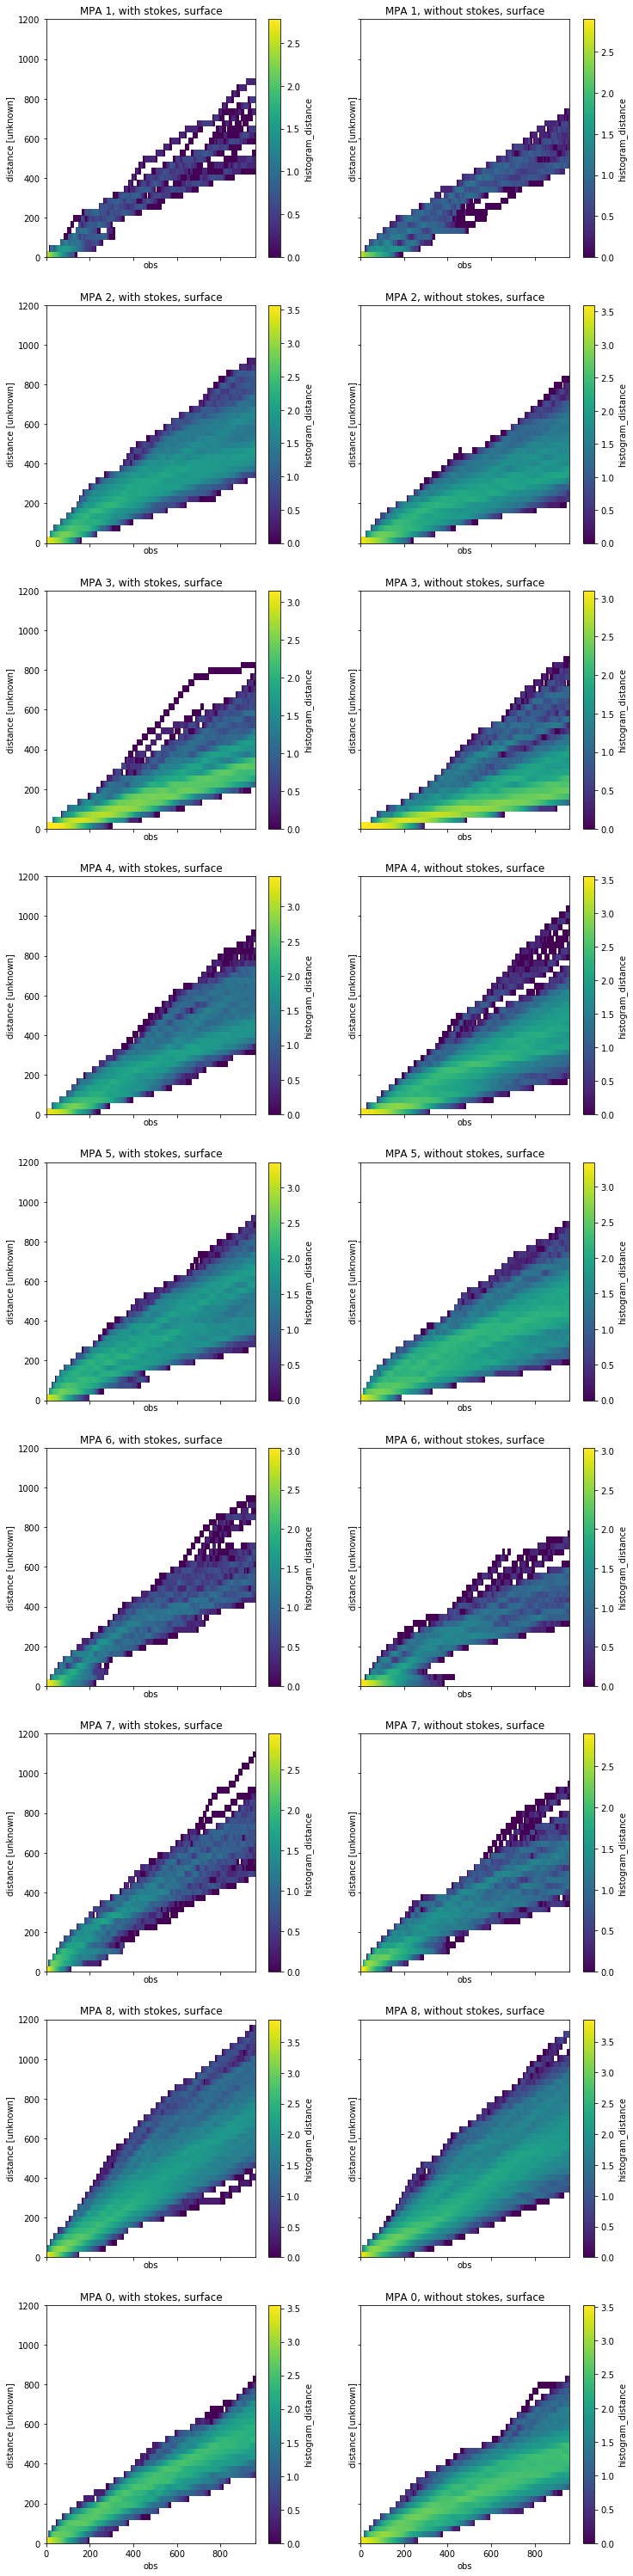

In [80]:
fig, ax = plt.subplots(9, 2, sharex=True, sharey=True, figsize=(12, 54))

for MPA in range(9):
    
    xr.ufuncs.log10(
        xhist(
            data.loc[True, MPA + 1, 0]["thinned_data_001_percent"].distance.persist(retries=40),
            bins=[np.linspace(0, 1200, 41), ],
            dim=["traj", ]).compute(retries=40)
    ).plot(ax=ax[MPA-1, 0], x="obs", y="distance_bin")
    ax[MPA-1, 0].set_title(f"MPA {MPA}, with stokes, surface")
    
    xr.ufuncs.log10(
        xhist(
            data.loc[False, MPA + 1, 0]["thinned_data_001_percent"].distance.persist(retries=40),
            bins=[np.linspace(0, 1200, 41), ],
            dim=["traj", ]).compute(retries=40)
    ).plot(ax=ax[MPA-1, 1], x="obs", y="distance_bin")
    ax[MPA-1, 1].set_title(f"MPA {MPA}, without stokes, surface")

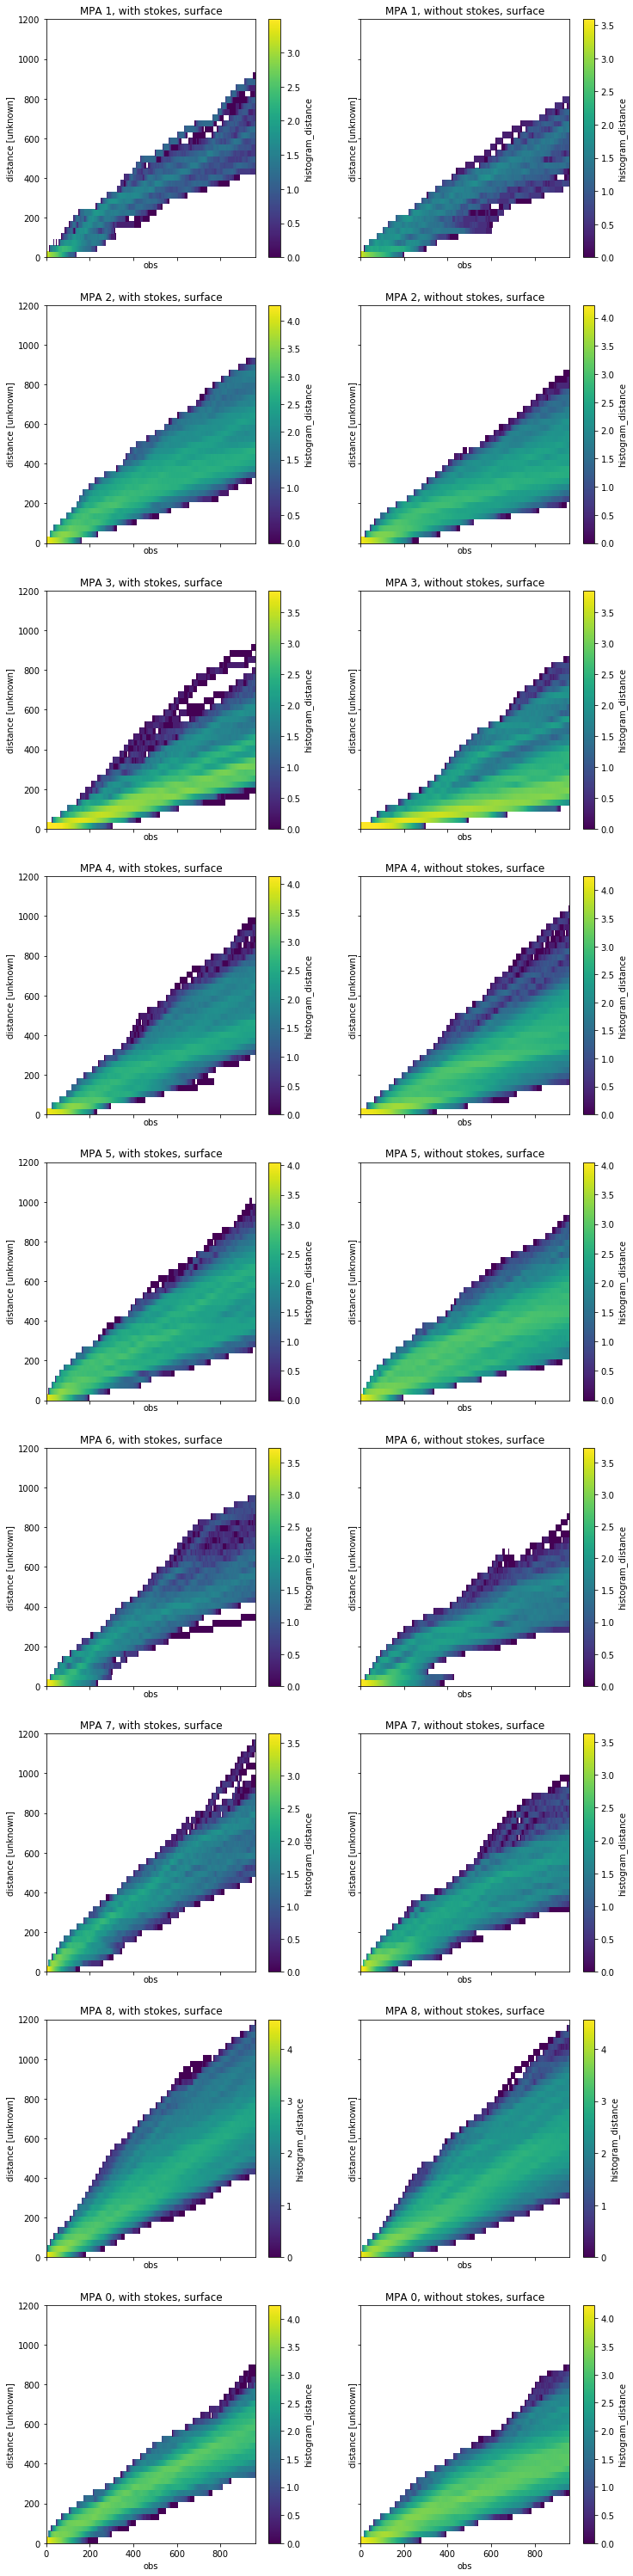

In [81]:
fig, ax = plt.subplots(9, 2, sharex=True, sharey=True, figsize=(12, 54))

for MPA in range(9):
    
    xr.ufuncs.log10(
        xhist(
            data.loc[True, MPA + 1, 0]["thinned_data_005_percent"].distance.persist(retries=40),
            bins=[np.linspace(0, 1200, 41), ],
            dim=["traj", ]).compute(retries=40)
    ).plot(ax=ax[MPA-1, 0], x="obs", y="distance_bin")
    ax[MPA-1, 0].set_title(f"MPA {MPA}, with stokes, surface")
    
    xr.ufuncs.log10(
        xhist(
            data.loc[False, MPA + 1, 0]["thinned_data_005_percent"].distance.persist(retries=40),
            bins=[np.linspace(0, 1200, 41), ],
            dim=["traj", ]).compute(retries=40)
    ).plot(ax=ax[MPA-1, 1], x="obs", y="distance_bin")
    ax[MPA-1, 1].set_title(f"MPA {MPA}, without stokes, surface")

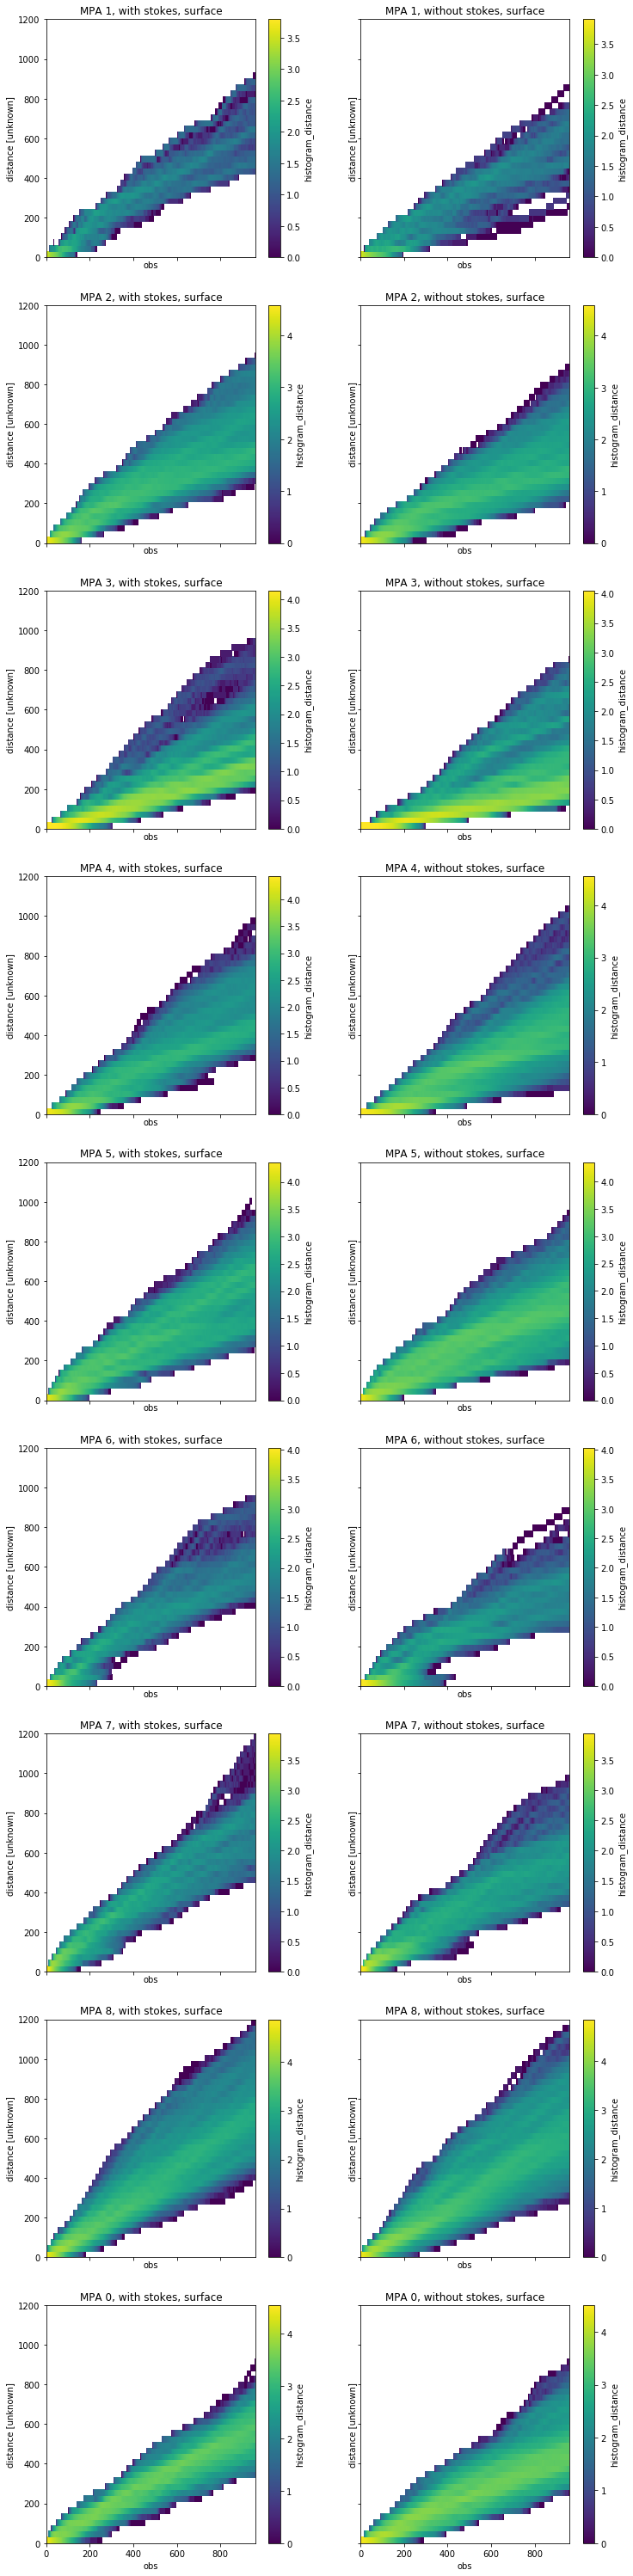

In [82]:
fig, ax = plt.subplots(9, 2, sharex=True, sharey=True, figsize=(12, 54))

for MPA in range(9):
    
    xr.ufuncs.log10(
        xhist(
            data.loc[True, MPA + 1, 0]["thinned_data_010_percent"].distance.persist(retries=40),
            bins=[np.linspace(0, 1200, 41), ],
            dim=["traj", ]).compute(retries=40)
    ).plot(ax=ax[MPA-1, 0], x="obs", y="distance_bin")
    ax[MPA-1, 0].set_title(f"MPA {MPA}, with stokes, surface")
    
    xr.ufuncs.log10(
        xhist(
            data.loc[False, MPA + 1, 0]["thinned_data_010_percent"].distance.persist(retries=40),
            bins=[np.linspace(0, 1200, 41), ],
            dim=["traj", ]).compute(retries=40)
    ).plot(ax=ax[MPA-1, 1], x="obs", y="distance_bin")
    ax[MPA-1, 1].set_title(f"MPA {MPA}, without stokes, surface")